# Многоуровневый анализ

Импортируем необходимые библиотеки.


Команда прогоняется в `Anaconda Prompt` 1 раз.
Нужно раскомментировать, прогнать и снова закомментировать.

In [1]:
# conda install -c anaconda seaborn=0.9.0

In [2]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки и функции для построения модели со смешанными эффектами (в частности, для проведения многоуровневого анализа)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

# Библиотеки для визуализации полученных результатов
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import math

In [4]:
from statsmodels.regression.mixed_linear_model import MixedLMParams

Открываем базу данных.

In [5]:
multilevel = pd.read_stata('multilevel_10.11 (1).dta')

Смотрим на описательные статистики нашей базы.

In [6]:
multilevel.head(10)

,house,state,lastname,votepct,party,money,acres
0,Senate,AK,Murkowski,0.842105,Republican,9.166,0.0
1,Senate,AK,Stevens,0.846154,Republican,0.000,0.0
2,House,AK,Young,0.571429,Republican,23.500,0.0
3,Senate,AL,Sessions,0.871795,Republican,-0.800,0.0
4,Senate,AL,Shelby,0.641026,Republican,24.166,0.0
5,House,AL,Aderholt,0.900000,Republican,35.000,0.0
6,House,AL,Bachus,0.666667,Republican,3.000,0.0
7,House,AL,Callahan,0.777778,Republican,5.500,0.0
8,House,AL,Cramer,0.888889,Democrat,14.050,0.0
9,House,AL,Everett,1.000000,Republican,6.000,0.0


In [7]:
multilevel.describe()

,votepct,money,acres
count,527.000000,527.000000,527.000000
mean,0.517968,12.955907,14.278861
std,0.348285,18.437599,41.497424
min,0.000000,-2.500000,0.000000
25%,0.200000,0.000000,0.000000
50%,0.594595,4.500000,0.000000
75%,0.846154,20.500000,6.500000
max,1.000000,113.100000,221.650000


In [8]:
multilevel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 526
Data columns (total 7 columns):
house       527 non-null category
state       527 non-null object
lastname    527 non-null object
votepct     527 non-null float64
party       527 non-null category
money       527 non-null float64
acres       527 non-null float64
dtypes: category(2), float64(3), object(2)
memory usage: 25.9+ KB


# Нулевая модель (без включения предикторов)

Прогоняем нулевую модель (на константу).

In [9]:
null = smf.mixedlm("votepct ~ 1",
                   data=multilevel,
                   groups=multilevel["state"]
                  ).fit()

In [10]:
null.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: votepct  
No. Observations: 527     Method:             REML     
No. Groups:       50      Scale:              0.0926   
Min. group size:  2       Likelihood:         -159.3981
Max. group size:  55      Converged:          Yes      
Mean group size:  10.5                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.531    0.031 16.861 0.000  0.469  0.593
groups RE     0.036    0.035                           
=======================================================

"""

Реализуем подсчет ICC, где:
* `Std.Err. of Group Var` = Variance of Intercept (аналог в R, `0.035`);
* `Scale` = Variance of Residual (аналог в R, `0.0926`).

In [11]:
0.035/(0.035+0.0926)

0.27429467084639503

Проверяем подсчет ICC, равномерно ли распределено групповое отклонение?

In [12]:
# создадим датасет с реальными группированными средними, где группа - штат, а значение - votepct.
multi_grouped = multilevel.groupby('state')['votepct'].mean()
multi_grouped_s = multi_grouped.sort_values()

In [13]:
# создаем все необходимые переменные для псевдоданных
x = list(multilevel['votepct'])
nreps = 1000
grpid = list(multilevel['state'])

matrix_nan = np.zeros((len(multi_grouped_s.index), nreps))
df_nan = pd.DataFrame(matrix_nan.fill(np.nan))

In [14]:
def string_to_numeric_factor(x):
    classnames, indices = np.unique(x, return_inverse=True)
    return indices

In [15]:
# аналог функции mix.data в R
def create_mixed_data_with_new_indexes(nreps, x, grpid, df_nan):
    for i in range(nreps):
        TDAT = pd.DataFrame({'random':np.random.normal(size=len(grpid)), 'grpid':grpid, 'x':x}).sort_values(by='random')
        TDAT['grpid'] = string_to_numeric_factor(TDAT['grpid'])
        newid = pd.DataFrame({'newid':list(TDAT[['grpid']].sort_values(by='grpid')['grpid'])})
        TOUT = pd.concat([newid.reset_index(drop=True),TDAT[['grpid', 'x']].reset_index(drop=True)], axis=1) 
        df_nan.loc[:, i] = list(TOUT.groupby('newid')['x'].mean().sort_values().values)
    return df_nan

In [16]:
df_random = create_mixed_data_with_new_indexes(nreps, x, grpid, df_nan)

In [17]:
# создание псевдосреднего значений, псевдозначений верхнего и нижнего квантилей
ps_mean = pd.DataFrame({"mean":list(df_random.mean(axis=1).values)})
ps_lci = pd.DataFrame({"lci":list(df_random.quantile(q=0.025, axis=1).values)})
ps_hci = pd.DataFrame({"hci":list(df_random.quantile(q=0.975, axis=1).values)})

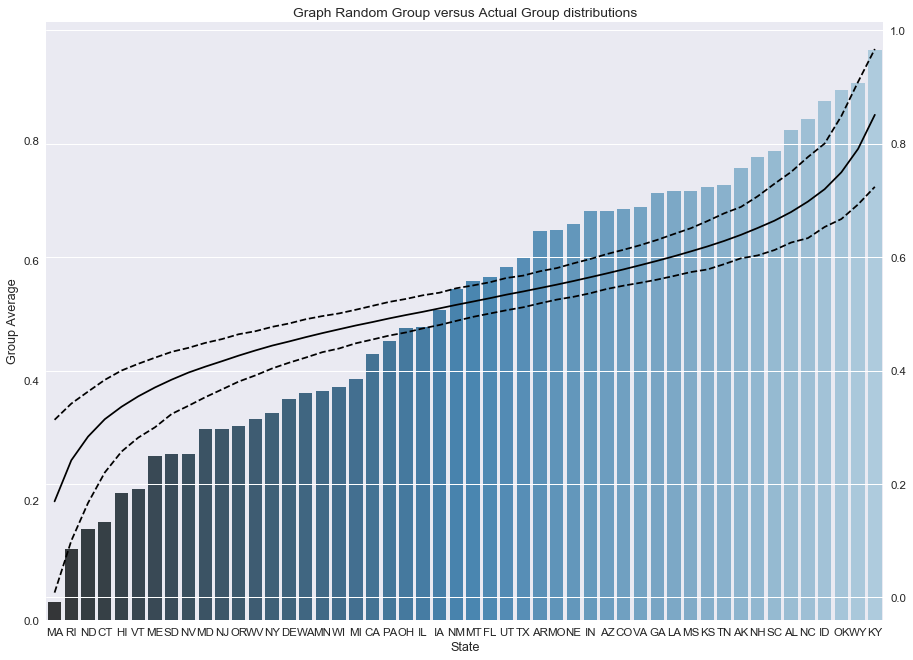

In [18]:
# распределение среднего группового для зависимой переменной
sns.set(rc={'figure.figsize':(15,11)},
        font_scale = 1.15,
       )
ax = sns.barplot(x = multi_grouped_s.index, y = multi_grouped_s.values, palette="Blues_d")
ax.set_title('Graph Random Group versus Actual Group distributions')
ax.set(xlabel='State', ylabel='Group Average')

# добавление линий псевдосредних значений, псевдозначений верхнего и нижнего квантилей на столбчатый график
ps_lci['lci'].plot(kind='line', linestyle='--', secondary_y=True, color='black')
ps_mean['mean'].plot(kind='line', secondary_y=True, color='black')
ps_hci['hci'].plot(kind='line', linestyle='--', secondary_y=True, color='black')

Посмотрим значение `p-value` константы, а также откроем словарь `случайных эффектов на константу` для нулевой модели.

In [19]:
null.pvalues

Intercept    8.760272e-64
groups RE    6.719947e-04
dtype: float64

In [20]:
null.random_effects

{'AK': groups    0.120273
 dtype: float64, 'AL': groups    0.222423
 dtype: float64, 'AR': groups    0.077868
 dtype: float64, 'AZ': groups    0.114955
 dtype: float64, 'CA': groups   -0.084415
 dtype: float64, 'CO': groups    0.116765
 dtype: float64, 'CT': groups   -0.278815
 dtype: float64, 'DE': groups   -0.088133
 dtype: float64, 'FL': groups    0.036846
 dtype: float64, 'GA': groups    0.150802
 dtype: float64, 'HI': groups   -0.19536
 dtype: float64, 'IA': groups   -0.011031
 dtype: float64, 'ID': groups    0.180719
 dtype: float64, 'IL': groups   -0.038191
 dtype: float64, 'IN': groups    0.122412
 dtype: float64, 'KS': groups    0.133628
 dtype: float64, 'KY': groups    0.307202
 dtype: float64, 'LA': groups    0.146669
 dtype: float64, 'MA': groups   -0.413861
 dtype: float64, 'MD': groups   -0.169856
 dtype: float64, 'ME': groups   -0.157182
 dtype: float64, 'MI': groups   -0.113688
 dtype: float64, 'MN': groups   -0.119402
 dtype: float64, 'MO': groups    0.097103
 dtype: f

# 1 модель (с включением 1-го предиктора индивидуального уровня)

Прогоняем модель с включением фиксированных эффектов для индивидуального уровня.

In [21]:
model1 = smf.mixedlm("votepct ~ money",
                     data=multilevel,
                     groups=multilevel["state"]
                    ).fit()

https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html

In [22]:
model1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: votepct  
No. Observations: 527     Method:             REML     
No. Groups:       50      Scale:              0.0822   
Min. group size:  2       Likelihood:         -123.8722
Max. group size:  55      Converged:          Yes      
Mean group size:  10.5                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.429    0.026 16.271 0.000  0.377  0.481
money         0.008    0.001  9.526 0.000  0.006  0.009
groups RE     0.018    0.023                           
=======================================================

"""

Посмотрим на полученные случайные эффекты на константу в модели с включением переменной индивидуального уровня.

In [23]:
model1.random_effects

{'AK': groups    0.095289
 dtype: float64, 'AL': groups    0.169434
 dtype: float64, 'AR': groups    0.093805
 dtype: float64, 'AZ': groups    0.114068
 dtype: float64, 'CA': groups   -0.035564
 dtype: float64, 'CO': groups    0.107141
 dtype: float64, 'CT': groups   -0.190001
 dtype: float64, 'DE': groups   -0.067758
 dtype: float64, 'FL': groups    0.043279
 dtype: float64, 'GA': groups    0.021535
 dtype: float64, 'HI': groups   -0.115818
 dtype: float64, 'IA': groups   -0.013804
 dtype: float64, 'ID': groups    0.125061
 dtype: float64, 'IL': groups   -0.004651
 dtype: float64, 'IN': groups    0.119207
 dtype: float64, 'KS': groups    0.130712
 dtype: float64, 'KY': groups    0.055314
 dtype: float64, 'LA': groups    0.094672
 dtype: float64, 'MA': groups   -0.288018
 dtype: float64, 'MD': groups   -0.104751
 dtype: float64, 'ME': groups   -0.080599
 dtype: float64, 'MI': groups   -0.0736
 dtype: float64, 'MN': groups   -0.094283
 dtype: float64, 'MO': groups    0.086994
 dtype: fl

Посмотрим, действительно ли случайные эффекты на константу значимо отличны? Перескают ли границы их доверительных интервалов 0?

In [24]:
def calc_sqrt_cov_const_random_effects(mixed_model):
    cov_data = list(mixed_model.random_effects_cov.values())
    cov_const = [cov_data[i].values[0][0] for i in range(len(cov_data))]
    sqrt_cov_const = [math.sqrt(cov_const[j]) for j in range(len(cov_const))]
    return sqrt_cov_const

In [25]:
# возьмем квадратный корень от каждого случайного эффекта в условной ковариционной матрице
sqrt_cov_const = calc_sqrt_cov_const_random_effects(model1)

In [26]:
def get_const_random_effects(mixed_model):
    random_eff_data = list(mixed_model.random_effects.values())
    random_eff_const = [random_eff_data[i].values[0] for i in range(len(random_eff_data))]
    return random_eff_const

In [27]:
# создадим отдельный датасет со значениями случайных эффектов на константу, штатами и полученными квадратными корнями
random_eff_const = get_const_random_effects(model1)
states = list(null.random_effects)
dt_for_graph = pd.DataFrame({'random_eff_const':random_eff_const, 'states':states, 
                             'sqrt_cov_const': sqrt_cov_const}
                           ).sort_values(by='random_eff_const',
                                         ascending=False
                                        )

In [28]:
# посмотрим на границы доверительного интервала 1-го штата (AK)
lci = random_eff_const[0] - sqrt_cov_const[0]*2
hci = random_eff_const[0] + sqrt_cov_const[0]*2
print(lci, hci)

-0.11263981366341716 0.3032175097196257


In [29]:
# в качестве новых индексов зададим названия штатов
dt_for_graph1 = dt_for_graph.copy()
values = dt_for_graph1.set_index('states')

<Container object of 3 artists>

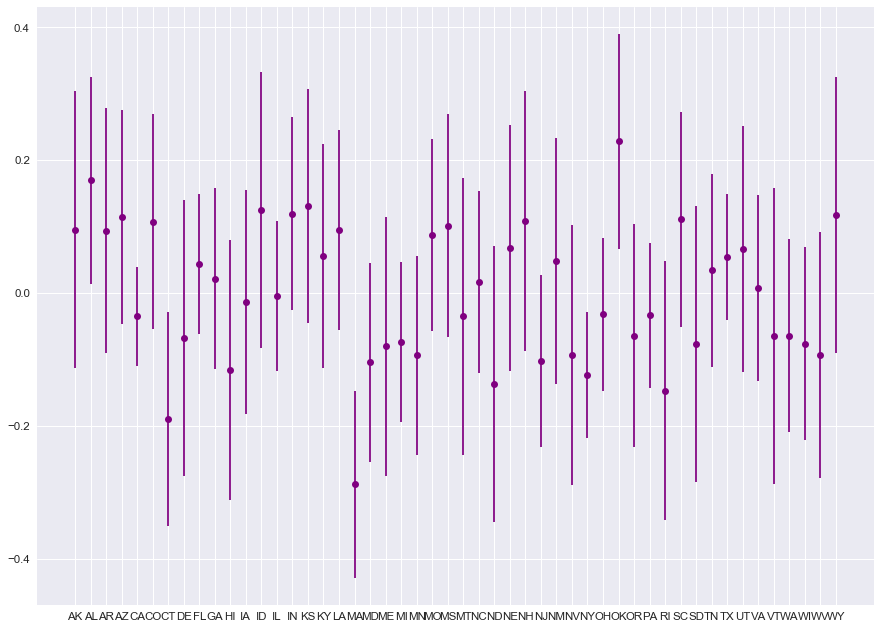

In [30]:
plt.errorbar(values.index, values.random_eff_const, yerr=2*values.sqrt_cov_const, 
             animated = True, color ='purple', fmt='o'
            )

То же самое только без границ доверительных интервалов.

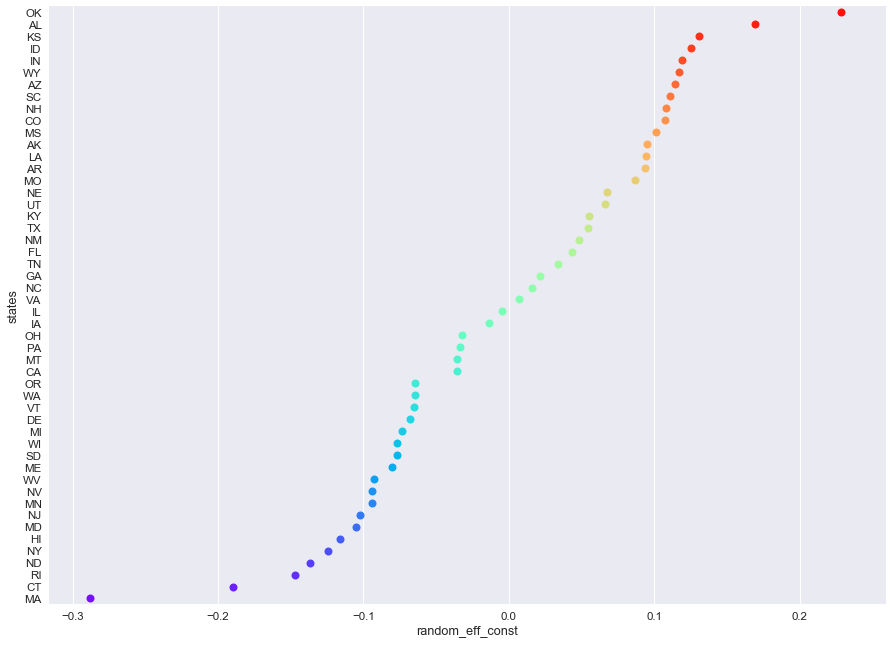

In [31]:
sns.stripplot(x='random_eff_const', y='states', data=dt_for_graph, palette='rainbow_r', size = 8)

Получим BLUP-значения для константы и на наклон (без включения случайных эффектов на наклон).

In [32]:
def get_constant_and_slope_BLUP_with_the_same_slope(mixed_model, name_of_individual_variable):
    random_eff_const = list(mixed_model.random_effects.values())
    BLUP_const = [random_eff_const[i].values[0] + mixed_model.params[0] for i in range(len(random_eff_const))]
    BLUP_slope = [mixed_model.params[name_of_individual_variable]] * len(BLUP_const)
    df_BLUP_const = pd.DataFrame({"State_unique":list(mixed_model.random_effects), 
                                  "BLUP_const": BLUP_const, "BLUP_slope": BLUP_slope
                                 }
                                )
    return df_BLUP_const

Видим, что наклон одинаков для всех штатов.

In [33]:
get_constant_and_slope_BLUP_with_the_same_slope(model1, 'money')

,BLUP_const,BLUP_slope,State_unique
0,0.524346,0.00759,AK
1,0.598492,0.00759,AL
2,0.522863,0.00759,AR
3,0.543125,0.00759,AZ
4,0.393494,0.00759,CA
5,0.536198,0.00759,CO
6,0.239056,0.00759,CT
7,0.361300,0.00759,DE
8,0.472336,0.00759,FL
9,0.450592,0.00759,GA


### Дополнительный вариант реализации данной модели

In [34]:
endog = multilevel["votepct"]
multilevel["Intercept"] = 0.429
exog = multilevel[["Intercept", "money"]]
groups = multilevel["state"]

In [35]:
model_dop = sm.MixedLM(endog, exog, groups = multilevel["state"], exog_re=exog["Intercept"]).fit()

# 2 модель (с включением 2-х предикторов индивидуального уровня)

Добавляем еще один предиктор индивидуального уровня.

In [36]:
model2 = smf.mixedlm("votepct ~ money + party",
                     data=multilevel,
                     groups=multilevel["state"]
                    ).fit()

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [37]:
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM   Dependent Variable:   votepct 
No. Observations:    527       Method:               REML    
No. Groups:          50        Scale:                0.0294  
Min. group size:     2         Likelihood:           142.8494
Max. group size:     55        Converged:            Yes     
Mean group size:     10.5                                    
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.200    0.018 11.400 0.000  0.166  0.234
party[T.Republican] 0.496    0.016 30.493 0.000  0.464  0.528
money               0.004    0.000  9.022 0.000  0.003  0.005
groups RE           0.006    0.014                           
=============================================================

"""

# 3 модель (с включением 1-го предиктора странового уровня)

Добавляем переменную второго уровня.

In [38]:
model3 = smf.mixedlm("votepct ~ money + party + acres",
                     data=multilevel,
                     groups=multilevel["state"]
                    ).fit()

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [39]:
model3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM   Dependent Variable:   votepct 
No. Observations:    527       Method:               REML    
No. Groups:          50        Scale:                0.0294  
Min. group size:     2         Likelihood:           137.6653
Max. group size:     55        Converged:            Yes     
Mean group size:     10.5                                    
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.193    0.018 10.999 0.000  0.159  0.228
party[T.Republican] 0.497    0.016 30.571 0.000  0.465  0.528
money               0.004    0.001  8.218 0.000  0.003  0.005
acres               0.001    0.000  1.947 0.052 -0.000  0.001
groups RE           0.006    0.013                           
=============================================================

"""

In [40]:
model3.cov_params()

,Intercept,party[T.Republican],money,acres,groups RE
Intercept,0.000308,-1.227392e-04,-1.693645e-06,-1.107353e-06,0.000074
party[T.Republican],-0.000123,2.638976e-04,-1.528050e-06,2.838678e-08,-0.000145
money,-0.000002,-1.528050e-06,2.574772e-07,-5.531912e-08,-0.000006
acres,-0.000001,2.838678e-08,-5.531912e-08,1.143341e-07,0.000002
groups RE,0.000074,-1.453625e-04,-5.838424e-06,1.781643e-06,0.005785


Теперь наша модель содержит как фиксированные эффекты для индивидуальных предикторов (`money`, `party`), так и фиксированные эффекты для переменной странового уровня (`acres`). Включим еще случайные эффекты для переменной первого уровня.

# 4_1 модель (с включением случайных эффектов на наклон и учетом допущения о скоррелированности случайных эффектов)

In [41]:
model4_1 = smf.mixedlm("votepct ~ money + party",
                     data=multilevel, 
                     groups=multilevel["state"],
                     re_formula="~party"
                    ).fit()

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [42]:
print(model4_1.summary())

                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         votepct 
No. Observations:           527             Method:                     REML    
No. Groups:                 50              Scale:                      0.0275  
Min. group size:            2               Likelihood:                 149.6499
Max. group size:            55              Converged:                  Yes     
Mean group size:            10.5                                                
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.213    0.023  9.353 0.000  0.168  0.257
party[T.Republican]                    0.488    0.023 21.692 0.000  0.444  0.532
money                                  0.004    0.

Случайные эффекты на константу и на наклон в данном случае скоррелированы и составляют:

In [43]:
-0.009/(np.sqrt(0.014*0.008))

-0.8504200642707611

Где:
* -0.009 - covariance of intercept and individual predictor (`Group x party[T.Republican] Cov`в выдаче);
* 0.014 - variance of intercept (`Group Var` в выдаче);
* 0.008 - variance of individual predictor (`party[T.Republican] Var` в выдаче).

Посмотрим на случайные эффекты на константу и наклон.

In [44]:
model4_1.random_effects

{'AK': Intercept              0.002258
 party[T.Republican]   -0.000184
 dtype: float64, 'AL': Intercept              0.216826
 party[T.Republican]   -0.141544
 dtype: float64, 'AR': Intercept              0.103032
 party[T.Republican]   -0.055878
 dtype: float64, 'AZ': Intercept              0.009750
 party[T.Republican]   -0.009488
 dtype: float64, 'CA': Intercept             -0.054717
 party[T.Republican]    0.087981
 dtype: float64, 'CO': Intercept              0.001512
 party[T.Republican]    0.036260
 dtype: float64, 'CT': Intercept             -0.143255
 party[T.Republican]    0.055915
 dtype: float64, 'DE': Intercept             -0.088555
 party[T.Republican]    0.010035
 dtype: float64, 'FL': Intercept              0.007214
 party[T.Republican]   -0.015382
 dtype: float64, 'GA': Intercept             -0.007566
 party[T.Republican]    0.026016
 dtype: float64, 'HI': Intercept             -0.012851
 party[T.Republican]    0.008114
 dtype: float64, 'IA': Intercept             -0.

Получим BLUP-значения для константы и на наклон (c включениtv случайных эффектов на наклон).

In [45]:
def get_constant_and_slope_BLUP_with_different_slope(mixed_model, name_of_individual_variable):
    random_eff_const = list(mixed_model.random_effects.values())
    BLUP_const = [random_eff_const[i].values[0] + mixed_model.params[0] for i in range(len(random_eff_const))]
    BLUP_slope = [random_eff_const[i].values[1] + mixed_model.params[name_of_individual_variable] for i in range(len(random_eff_const))]
    df_BLUP_slope = pd.DataFrame({"State_unique":list(mixed_model.random_effects), 
                                  "BLUP_const": BLUP_const, "BLUP_slope": BLUP_slope
                                 }
                                )
    return df_BLUP_slope

In [46]:
get_constant_and_slope_BLUP_with_different_slope(model4_1, 'party[T.Republican]')

,BLUP_const,BLUP_slope,State_unique
0,0.215143,0.487998,AK
1,0.429711,0.346638,AL
2,0.315917,0.432304,AR
3,0.222635,0.478694,AZ
4,0.158169,0.576162,CA
5,0.214398,0.524441,CO
6,0.069630,0.544097,CT
7,0.124331,0.498216,DE
8,0.220100,0.472799,FL
9,0.205319,0.514197,GA


Посмотрим визуализацию случайных эффектов на константу и наклон с их границами доверительных интервалов.

In [47]:
# возьмем квадратный корень от каждого случайного эффекта на константу в условной ковариционной матрице
sqrt_cov_const4_1 = calc_sqrt_cov_const_random_effects(model4_1)

In [48]:
def calc_sqrt_cov_slope_random_effects(mixed_model):
    cov_data = list(mixed_model.random_effects_cov.values())
    cov_slope = [cov_data[i].values[1][1] for i in range(len(cov_data))]
    sqrt_cov_slope = [math.sqrt(cov_slope[j]) for j in range(len(cov_slope))]
    return sqrt_cov_slope

In [49]:
# возьмем квадратный корень от каждого случайного эффекта на наклон в условной ковариционной матрице
sqrt_cov_slope4_1 = calc_sqrt_cov_slope_random_effects(model4_1)

In [50]:
def get_slope_random_effects(mixed_model):
    random_eff = list(mixed_model.random_effects.values())
    random_eff_slope = [random_eff[i].values[1] for i in range(len(random_eff))]
    return random_eff_slope

In [51]:
# получаем в качестве списков случайные эффекты на константу и наклон
# создадим отдельный датасет со значениями случайных эффектов на константу, штатами и полученными квадратными корнями
random_eff_const4_1 = get_const_random_effects(model4_1)
random_eff_slope4_1 = get_slope_random_effects(model4_1)
dt_for_graph4_1 = pd.DataFrame({'random_eff_const':random_eff_const4_1,
                             'states':states, 
                             'sqrt_cov_const': sqrt_cov_const4_1,
                             'random_eff_slope': random_eff_slope4_1,
                            'sqrt_cov_slope': sqrt_cov_slope4_1
                               }
                              ).sort_values(by='random_eff_const',
                                         ascending=False
                                        )

In [52]:
# в качестве новых индексов зададим названия штатов
values4_1 = dt_for_graph4_1.set_index('states')

График случайных эффектов на константу

<Container object of 3 artists>

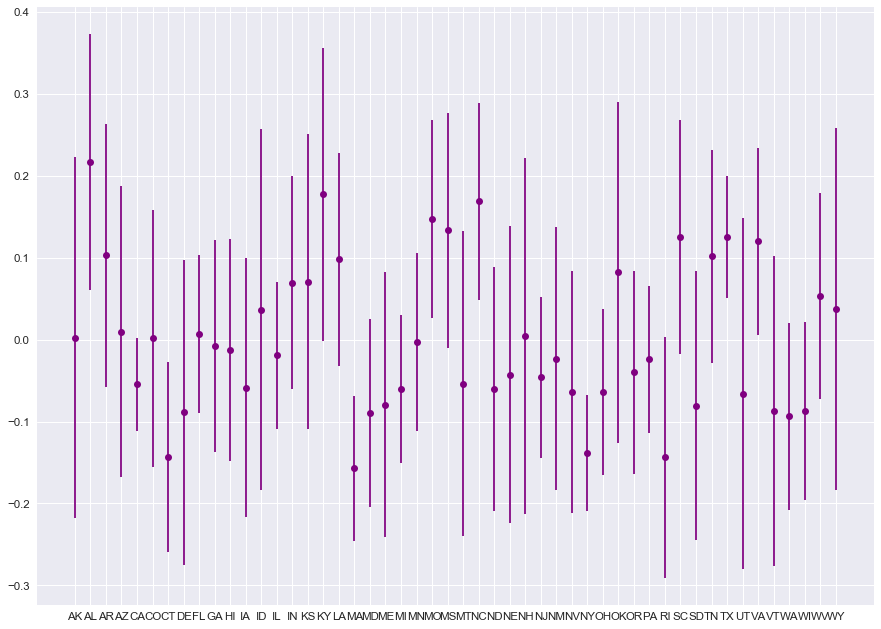

In [53]:
plt.errorbar(values4_1.index, values4_1.random_eff_const, 
             yerr=2*values4_1.sqrt_cov_const, 
             animated = True, color ='purple', fmt='o'
            )

График случайных эффектов на наклон

<Container object of 3 artists>

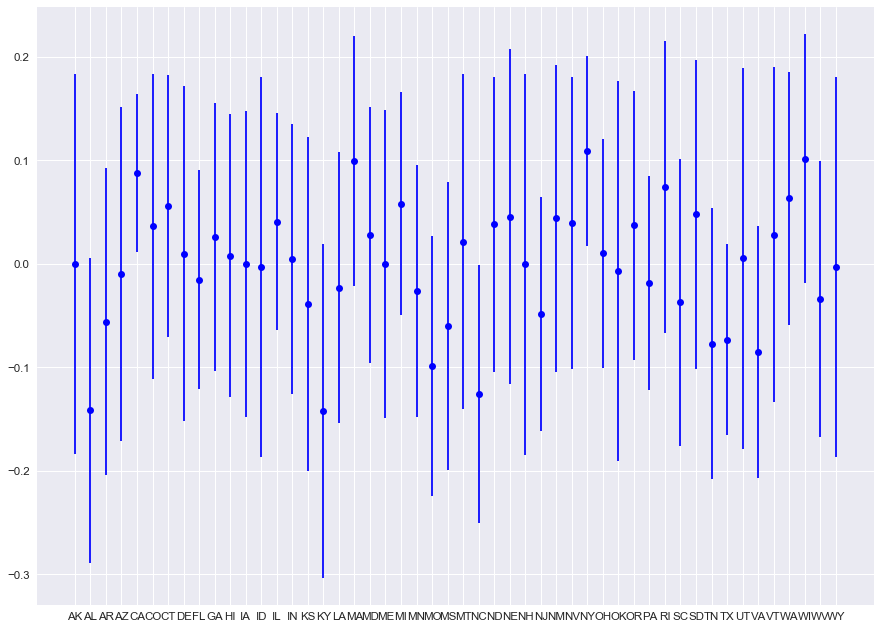

In [54]:
plt.errorbar(values4_1.index, values4_1.random_eff_slope, 
             yerr=2*values4_1.sqrt_cov_slope, 
             animated = True, color ='blue', fmt='o'
            )

# 4_2 модель (с включением случайных эффектов на наклон и отсутствием допущения о скоррелированности случайных эффектов)

Построим такую же модель с отстуствием допущения о скоррелированности случайных эффектов на константу и наклон. Для начала узнаем размерность ковариационной матрицы случайных эффектов.

In [55]:
model4_1.cov_re

,Intercept,party[T.Republican]
Intercept,0.014102,-0.008904
party[T.Republican],-0.008904,0.008481


Внесем изменения в данную матрицу через аргумент `free` и посмотрим основную выдачу по модели. Не забудем, что количество фиксированных эффектов в предшествующей модели составило 3: для константы и для двух переменных индивидуального уровня. А также было 2 вида случайных эффектов на константу и наклон. В связи с чем измнения в матрицу буду внесены с учетом данной информации: количество замененных 1 будет равно количеству фиксированных эффектов, а через np.eye() зададим размерность (равно количеству видов случайных эффектов) 2-D array с единицами по главной диагонали и нулями в других ячейках.

In [56]:
model4 = smf.mixedlm("votepct ~ money + party",
                     data=multilevel, 
                     groups=multilevel["state"],
                     re_formula="~party"
                    )
free1 = MixedLMParams.from_components(np.ones(3),
                                     np.eye(2)
                                    )
model4_2 = model4.fit(free=free1)
print(model4_2.summary())

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         votepct 
No. Observations:          527             Method:                     REML    
No. Groups:                50              Scale:                      0.0281  
Min. group size:           2               Likelihood:                 144.7038
Max. group size:           55              Converged:                  Yes     
Mean group size:           10.5                                                
-------------------------------------------------------------------------------
                                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             0.204    0.018 11.081 0.000  0.168  0.240
party[T.Republican]                   0.487    0.019 25.019 0.000  0.449  0.525
money                                 0.004    0.000  8.949 0

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Посмотрим на размерность и содержания новой матрицы в аргументе `free`.

In [57]:
free1.cov_re

array([[1., 0.],
       [0., 1.]])

Проверим, действительно ли в модели отсутствует допущение о скоррелированности случайных эффектов.

In [58]:
0/(np.sqrt(0.007*0.003))

0.0

Посмотрим на визуализацию случайных эффектов

In [59]:
sqrt_cov_const4_2 = calc_sqrt_cov_const_random_effects(model4_2)
sqrt_cov_slope4_2 = calc_sqrt_cov_slope_random_effects(model4_2)
random_eff_const4_2 = get_const_random_effects(model4_2)
random_eff_slope4_2 = get_slope_random_effects(model4_2)

In [60]:
dt_for_graph4_2 = pd.DataFrame({'random_eff_const':random_eff_const4_2,
                             'states':states, 
                             'sqrt_cov_const': sqrt_cov_const4_2,
                             'random_eff_slope': random_eff_slope4_2,
                            'sqrt_cov_slope': sqrt_cov_slope4_2
                               }
                              ).sort_values(by='random_eff_const',
                                         ascending=False
                                        )

In [61]:
values4_2 = dt_for_graph4_2.set_index('states')

<Container object of 3 artists>

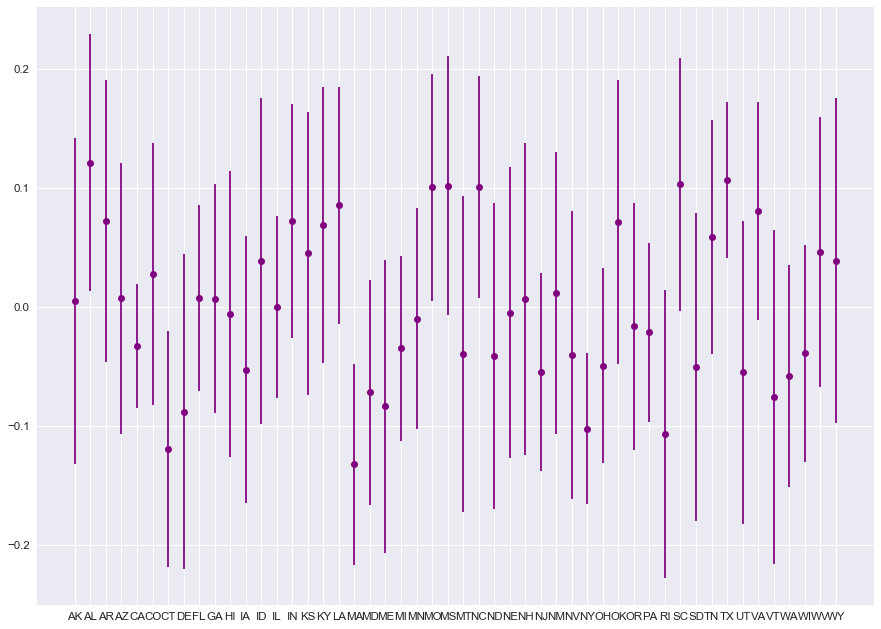

In [62]:
plt.errorbar(values4_2.index, values4_2.random_eff_const, 
             yerr=2*values4_2.sqrt_cov_const, 
             animated = True, color ='purple', fmt='o'
            )

<Container object of 3 artists>

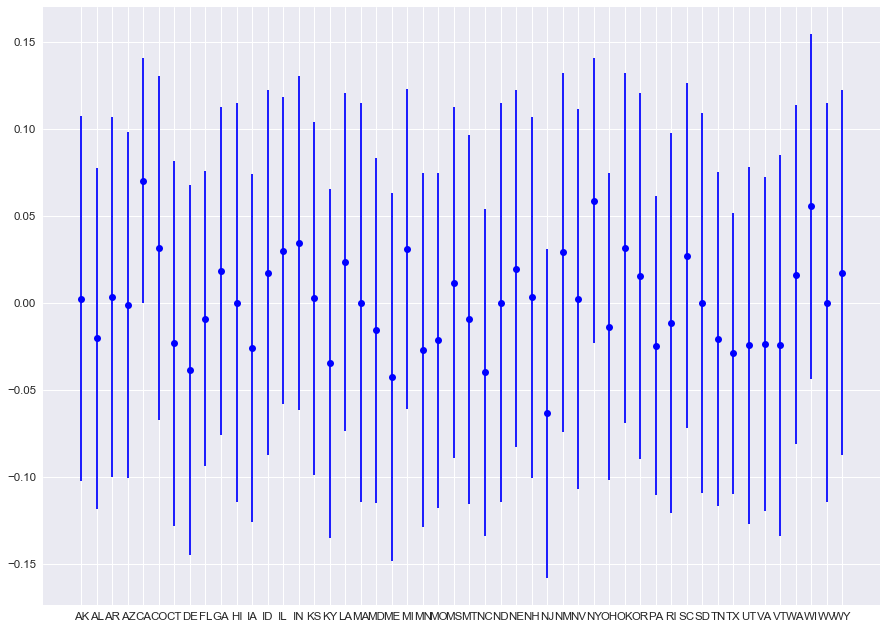

In [63]:
plt.errorbar(values4_2.index, values4_2.random_eff_slope, 
             yerr=2*values4_2.sqrt_cov_slope, 
             animated = True, color ='blue', fmt='o'
            )

# 5 модель (с включением переменной взаимодействия между предикторами индивидуального и странового уровня)

Построим модель с включением переменных первого и второго уровня, а также с добавлением переменной взаимодействия `acres` и `party`.

In [64]:
model5 = smf.mixedlm("votepct ~ money + party + acres + party*acres",
                     data=multilevel, 
                     groups=multilevel["state"],
                     re_formula="~party"
                    ).fit()

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [65]:
model5.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                      MixedLM         Dependent Variable:         votepct 
No. Observations:           527             Method:                     REML    
No. Groups:                 50              Scale:                      0.0272  
Min. group size:            2               Likelihood:                 143.3753
Max. group size:            55              Converged:                  Yes     
Mean group size:            10.5                                                
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.186    0.021  8.926 0.000  0.145  0.227
party[T.Republican]                    0.516    0.022 23.685 0.000  0.473  0.558
money                                  0.004    0.000  8.040 0.000  0.003  0.005
acres                                  0.002    0.000  3.905 0.000  0.001  0.003
party[T.Republican]:acres             -0.002    0.000 -3.647 0.000 -0.003 -0.001
Intercept RE                           0.010    0.023                           
Intercept RE x party[T.Republican] RE -0.005    0.019                           
party[T.Republican] RE                 0.005    0.021                           
================================================================================

"""

# 6_1 модель (с использованием grand-mean для переменной индивидуального уровня `money`)

Рассмотрим модель с включением преобразованной переменной индивидуального уровня. Для этого создадим новую переменную посредством вычитания из каждого значения предиктора `money` среднее значение данной переменной для всех штатов в базе.

In [66]:
mean = multilevel['money'].mean()
multilevel['money_minus_grand_mean'] = multilevel['money'].map(lambda x: x-mean)

In [67]:
model6_1 = smf.mixedlm("votepct ~ money_minus_grand_mean + party + acres + money_minus_grand_mean*acres",
                     data=multilevel, 
                     groups=multilevel["state"]
                      ).fit()

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [68]:
model6_1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                   MixedLM      Dependent Variable:      votepct 
No. Observations:        527          Method:                  REML    
No. Groups:              50           Scale:                   0.0289  
Min. group size:         2            Likelihood:              133.2918
Max. group size:         55           Converged:               Yes     
Mean group size:         10.5                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.248    0.017 14.663 0.000  0.215  0.282
party[T.Republican]           0.491    0.016 30.410 0.000  0.459  0.523
money_minus_grand_mean        0.005    0.001  9.048 0.000  0.004  0.006
acres                         0.001    0.000  3.745 0.000  0.001  0.002
money_minus_grand_mean:acres -0.000    0.000 -3.631 0.000 -0.000 -0.000
groups RE                     0.005    0.012                           
=======================================================================

"""

# 6_2 модель (с использованием group-mean для переменной индивидуального уровня `money`)

Рассмотрим модель с включением преобразованной переменной индивидуального уровня. Для этого создадим новую переменную посредством вычитания из каждого значения предиктора `money` среднее значение данной переменной по каждому штату.

In [69]:
multilevel['money_minus_group_mean'] = multilevel['money'] - \
                            multilevel.groupby(['state'])['money'].transform('mean')

In [70]:
model6_2 = smf.mixedlm("votepct ~ money_minus_group_mean + party + acres + money_minus_group_mean*acres",
                     data=multilevel, 
                     groups=multilevel["state"]
                      ).fit()

In [71]:
model6_2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                   MixedLM      Dependent Variable:      votepct 
No. Observations:        527          Method:                  REML    
No. Groups:              50           Scale:                   0.0288  
Min. group size:         2            Likelihood:              124.3624
Max. group size:         55           Converged:               Yes     
Mean group size:         10.5                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.235    0.020 11.893 0.000  0.196  0.274
party[T.Republican]           0.494    0.016 30.250 0.000  0.462  0.526
money_minus_group_mean        0.005    0.001  7.889 0.000  0.003  0.006
acres                         0.002    0.000  4.177 0.000  0.001  0.002
money_minus_group_mean:acres -0.000    0.000 -2.985 0.003 -0.000 -0.000
groups RE                     0.010    0.018                           
=======================================================================

"""

# 6_3 модель (без центрирования)

In [72]:
model6_3 = smf.mixedlm("votepct ~ money + party + acres + money*acres",
                     data=multilevel, 
                     groups=multilevel["state"]
                      ).fit()

C:\Users\Alii\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [73]:
model6_3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   votepct 
No. Observations:     527       Method:               REML    
No. Groups:           50        Scale:                0.0289  
Min. group size:      2         Likelihood:           133.2918
Max. group size:      55        Converged:            Yes     
Mean group size:      10.5                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.182    0.017 10.523 0.000  0.148  0.215
party[T.Republican]  0.491    0.016 30.410 0.000  0.459  0.523
money                0.005    0.001  9.048 0.000  0.004  0.006
acres                0.002    0.000  3.998 0.000  0.001  0.003
money:acres         -0.000    0.000 -3.631 0.000 -0.000 -0.000
groups RE            0.005    0.012                           
==============================================================

"""

Сравним случайные эффекты на константу для моделей с разными типами центрирования и без центрирования.

In [74]:
random_eff_const6_1 = get_const_random_effects(model6_1)
random_eff_const6_2 = get_const_random_effects(model6_2)
random_eff_const6_3 = get_const_random_effects(model6_3)

In [75]:
pd.DataFrame({'6_1': random_eff_const6_1,
              '6_2': random_eff_const6_2,
              '6_3': random_eff_const6_3})

,6_1,6_2,6_3
0,0.008747,0.012536,0.008747
1,0.102652,0.149483,0.102652
2,0.070391,0.074404,0.070391
3,0.007890,0.005555,0.007890
4,0.010274,-0.007433,0.010274
5,0.045436,0.058527,0.045436
6,-0.101441,-0.146975,-0.101441
7,-0.077845,-0.100095,-0.077845
8,0.003960,0.010194,0.003960
9,-0.009627,0.067247,-0.009627


Визуализация случайных эффектов на константу

In [76]:
sqrt_cov_const6_3 = calc_sqrt_cov_const_random_effects(model6_3)
random_eff_const6_3 = get_const_random_effects(model6_3)

In [77]:
dt_for_graph6_3 = pd.DataFrame({'random_eff_const':random_eff_const6_3, 'states':states, 
                             'sqrt_cov_const': sqrt_cov_const6_3}
                           ).sort_values(by='random_eff_const',
                                         ascending=False
                                        )

In [78]:
values6_3 = dt_for_graph6_3.set_index('states')

<Container object of 3 artists>

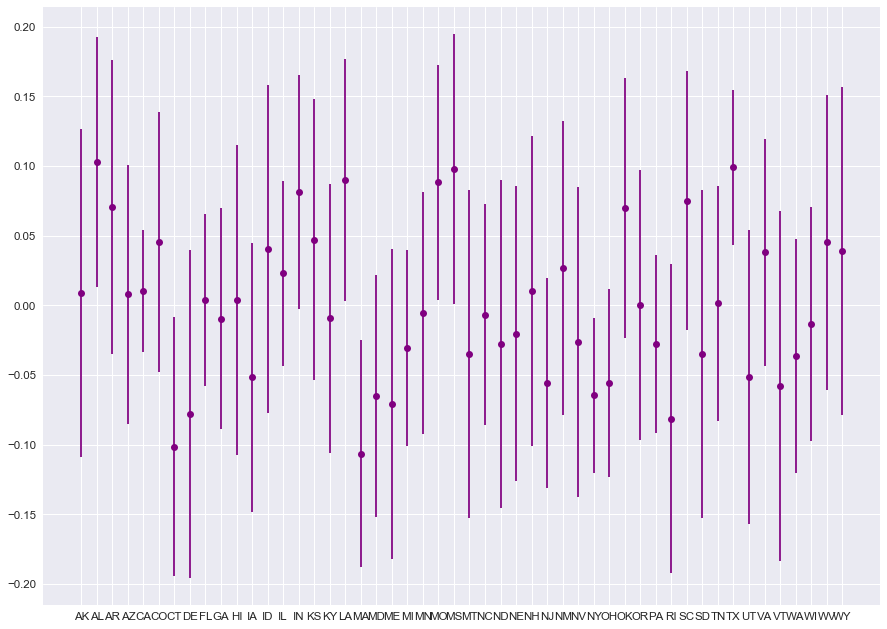

In [79]:
plt.errorbar(values6_3.index, values6_3.random_eff_const, 
             yerr=2*values6_3.sqrt_cov_const, 
             animated = True, color ='purple', fmt='o'
            )